# Chapter 6: Multiple Regression Analysis - Further Issues

:::{important} Learning Objectives
:class: dropdown

Upon completion of this chapter, readers will demonstrate proficiency in advanced regression modeling using Python by:

**6.1** Implementing logarithmic transformations of variables using NumPy log functions and interpreting semi-elasticities and elasticities from regression output.

**6.2** Estimating models with quadratic terms and computing turning points through coefficient manipulation and calculus in Python.

**6.3** Creating and interpreting interaction terms between continuous and categorical variables using patsy formulas and pandas operations.

**6.4** Computing standardized regression coefficients through z-score normalization with pandas and NumPy for comparing effect magnitudes.

**6.5** Generating prediction intervals using statsmodels get_prediction method with confidence bands for out-of-sample forecasting.

**6.6** Implementing adjusted R-squared calculations and conducting model comparison using information criteria (AIC, BIC) from statsmodels.

**6.7** Visualizing nonlinear relationships and interactions through conditional effect plots using seaborn and matplotlib.

**6.8** Automating functional form testing including quadratic specification tests and interaction significance assessment.
:::

Advanced applications of multiple regression require careful attention to model specification, functional form selection, and prediction methodology. This chapter extends foundational regression concepts to address practical challenges in empirical research: choosing appropriate transformations of variables, modeling interaction effects, incorporating quadratic relationships, and constructing prediction intervals that account for multiple sources of uncertainty.

The development proceeds hierarchically from data scaling considerations to sophisticated modeling techniques. We examine how changes in measurement units affect coefficient interpretation (Section 6.1), introduce logarithmic transformations for modeling percentage effects and elasticities (Section 6.2), develop methods for incorporating quadratic and interaction terms (Section 6.3), address challenges in standardized coefficients and goodness-of-fit measures (Section 6.4), and conclude with prediction theory and interval construction (Section 6.5-6.6). Throughout, we implement these methods using Python's statsmodels library and illustrate applications with real datasets from econometric research.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import wooldridge as wool
from scipy import stats

## 6.1 Model Formulae

This section explores how to use model formulae effectively to specify different types of regression models beyond the basic linear form. We will cover data scaling, standardization, the use of logarithms, quadratic and polynomial terms, and interaction effects. These techniques allow us to capture more complex relationships between variables and improve the fit and interpretability of our regression models.

### 6.1.1 Data Scaling: Arithmetic Operations within a Formula

Sometimes, the units in which variables are measured can affect the magnitude and interpretation of regression coefficients.  Scaling variables, such as dividing by a constant, can be useful for presenting coefficients in a more meaningful way.  `statsmodels` allows for arithmetic operations directly within the model formula, making it convenient to scale variables during model specification.

Consider the following model investigating the determinants of birth weight:

$$ \text{bwght} = \beta_0 + \beta_1 \cdot \text{cigs} + \beta_2 \cdot \text{faminc} + u$$

where:
- `bwght` is birth weight in ounces.
- `cigs` is the average number of cigarettes smoked per day by the mother during pregnancy.
- `faminc` is family income.

We might want to express birth weight in pounds instead of ounces or cigarettes in packs per day instead of individual cigarettes. Let's see how this can be done and how it affects the coefficients.

In [2]:
bwght = wool.data("bwght")

# regress and report coefficients:
reg = smf.ols(formula="bwght ~ cigs + faminc", data=bwght)
results = reg.fit()

# weight in pounds, manual way:
bwght["bwght_lbs"] = bwght["bwght"] / 16  # 1 pound = 16 ounces
reg_lbs = smf.ols(formula="bwght_lbs ~ cigs + faminc", data=bwght)
results_lbs = reg_lbs.fit()

# weight in pounds, direct way:
reg_lbs2 = smf.ols(
    formula="I(bwght/16) ~ cigs + faminc",
    data=bwght,
)  # Use I() to perform arithmetic within formula
results_lbs2 = reg_lbs2.fit()

# packs of cigarettes:
reg_packs = smf.ols(
    formula="bwght ~ I(cigs/20) + faminc",
    data=bwght,
)  # Assuming 20 cigarettes per pack
results_packs = reg_packs.fit()

# compare results:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "b_lbs": round(results_lbs.params, 4),
        "b_lbs2": round(results_lbs2.params, 4),
        "b_packs": round(results_packs.params, 4),
    },
)
table

,b,b_lbs,b_lbs2,b_packs
I(cigs / 20),NaN,NaN,NaN,-9.2682
Intercept,116.9741,7.3109,7.3109,116.9741
cigs,-0.4634,-0.0290,-0.0290,NaN
faminc,0.0928,0.0058,0.0058,0.0928


**Interpretation of Results:**

- **`b` (bwght):** This column shows the coefficients when birth weight is in ounces and cigarettes are in individual units.  For example, the coefficient for `cigs` is approximately -0.4638, meaning that, holding family income constant, each additional cigarette smoked per day is associated with a decrease in birth weight of about 0.46 ounces.
- **`b_lbs` and `b_lbs2` (bwght_lbs):** These columns show the coefficients when birth weight is converted to pounds. Notice that the coefficients for `b_lbs` (manual conversion) and `b_lbs2` (direct conversion in formula) are identical.  The coefficient for `cigs` is now approximately -0.0290. This is exactly the coefficient from the first regression divided by 16 (-0.4638 / 16 ~= -0.0290), as expected.  An additional cigarette is now associated with a decrease of about 0.029 pounds in birth weight.
- **`b_packs` (packs of cigs):**  Here, cigarettes are converted to packs (assuming 20 cigarettes per pack) within the formula. The coefficient for `I(cigs/20)` is approximately -9.2762. This is 20 times the coefficient from the first regression (-0.4638 * 20 ~= -9.276), as expected. One additional pack of cigarettes smoked per day is associated with a decrease of about 9.27 ounces in birth weight.

**Key takeaway:** Scaling the dependent or independent variables changes the scale of the corresponding regression coefficients but does not fundamentally alter the relationship being estimated.  It's crucial to be mindful of the units and choose scaling that makes the coefficients easily interpretable in the context of the problem. Using `I()` within the formula allows for convenient on-the-fly scaling.

### 6.1.2 Standardization: Beta Coefficients

Standardization involves transforming variables to have a mean of zero and a standard deviation of one.  This is particularly useful when comparing the relative effects of independent variables measured in different units.  The coefficients obtained from regressions with standardized variables are called *beta coefficients* or *standardized coefficients*. They represent the change in the dependent variable (in standard deviation units) for a one standard deviation change in the independent variable, holding other factors constant.

The standardization formula for a variable $x$ is:

$$z_x = \frac{x - \bar{x}}{\text{sd}(x)}$$

where $\bar{x}$ is the sample mean and $\text{sd}(x)$ is the sample standard deviation of $x$.

Let's revisit the housing price example and standardize some of the variables to obtain beta coefficients.

### Example 6.1: Effects of Pollution on Housing Prices (Standardized Variables)

We consider a model to examine the effect of air pollution (`nox`, nitrogen oxide concentration) and other factors on housing prices (`price`). We'll standardize `price`, `nox`, `crime`, `rooms`, `dist` (distance to employment centers), and `stratio` (student-teacher ratio).

$$\text{price\_sc} = \beta_0 + \beta_1 \cdot \text{nox\_sc} + \beta_2 \cdot \text{crime\_sc} + \beta_3 \cdot \text{rooms\_sc} + \beta_4 \cdot \text{dist\_sc} + \beta_5 \cdot \text{stratio\_sc} + u$$

where the `_sc` suffix denotes the standardized version of each variable.

In [3]:
# define a function for the standardization:
def scale(x):
    x_mean = np.mean(x)
    x_var = np.var(x, ddof=1)  # ddof=1 for sample standard deviation (denominator n-1)
    x_scaled = (x - x_mean) / np.sqrt(x_var)
    return x_scaled


# standardize and estimate:
hprice2 = wool.data("hprice2")
hprice2["price_sc"] = scale(hprice2["price"])
hprice2["nox_sc"] = scale(hprice2["nox"])
hprice2["crime_sc"] = scale(hprice2["crime"])
hprice2["rooms_sc"] = scale(hprice2["rooms"])
hprice2["dist_sc"] = scale(hprice2["dist"])
hprice2["stratio_sc"] = scale(hprice2["stratio"])

reg = smf.ols(
    formula="price_sc ~ 0 + nox_sc + crime_sc + rooms_sc + dist_sc + stratio_sc",  # No constant needed after standardization if all variables are standardized
    data=hprice2,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table

,b,se,t,pval
nox_sc,-0.3404,0.0445,-7.6511,0.0
crime_sc,-0.1433,0.0307,-4.6693,0.0
rooms_sc,0.5139,0.0300,17.1295,0.0
dist_sc,-0.2348,0.0430,-5.4641,0.0
stratio_sc,-0.2703,0.0299,-9.0274,0.0


**Interpretation of Beta Coefficients:**

- **`nox_sc` coefficient (-0.3404):**  A one standard deviation increase in nitrogen oxide concentration (`nox`) is associated with a decrease of 0.3404 standard deviations in housing price, holding other standardized variables constant.
- **`rooms_sc` coefficient (0.5139):** A one standard deviation increase in the number of rooms (`rooms`) is associated with an increase of 0.5139 standard deviations in housing price, holding other standardized variables constant.

**Comparing Effects:**

By comparing the absolute values of the beta coefficients, we can get a sense of the relative importance of each independent variable in explaining the variation in the dependent variable. In this example, `rooms_sc` has the largest beta coefficient (in absolute value), suggesting that the number of rooms has the strongest relative effect on housing price among the variables considered in the standardized model.  However, remember that "importance" here is in terms of explaining variance, not necessarily causal importance.

**Note on Constant Term:** When all variables (dependent and independent) are standardized and a constant is included in the regression, the constant will always be zero.  Therefore, it's common practice to suppress the constant term (by using `formula="price_sc ~ 0 + ..."` or `formula="price_sc ~ -1 + ..."`) when working with standardized variables, as done in the example above.

### 6.1.3 Logarithms

Logarithmic transformations are frequently used in regression analysis for several reasons:

1. **Nonlinearity:** Log transformations can linearize relationships that are nonlinear in levels.
2. **Heteroskedasticity:** They can help reduce heteroskedasticity in the error term.
3. **Interpretation:** Coefficients in log-transformed models often have convenient percentage change interpretations.

Common log transformations include:

- **Log-level model:**  $\log(y) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + u$.  Here, a one-unit change in $x_1$ is associated with approximately a $100 \cdot \beta_1$ percent change in $y$. This approximation is accurate when $|\beta_1|$ is small (typically $|\beta_1| < 0.1$); the exact percentage change is $100 \cdot [\exp(\beta_1) - 1]$ percent.
- **Level-log model:** $y = \beta_0 + \beta_1 \log(x_1) + \beta_2 x_2 + u$.  Here, a 1% increase in $x_1$ is associated with approximately a $\beta_1 / 100$ unit change in $y$. More precisely, the change in $y$ from increasing $x_1$ by factor $c$ (e.g., $c=1.01$ for 1%) is $\beta_1 \cdot \log(c)$.
- **Log-log model:** $\log(y) = \beta_0 + \beta_1 \log(x_1) + \beta_2 \log(x_2) + u$. Here, a 1% change in $x_1$ is associated with a $\beta_1$ percent change in $y$. The coefficient $\beta_1$ is the **elasticity** of $y$ with respect to $x_1$, and this interpretation is exact, not an approximation.

Let's consider a log-log model for housing prices:

$$\log(\text{price}) = \beta_0 + \beta_1 \log(\text{nox}) + \beta_2 \text{rooms} + u$$

In [4]:
hprice2 = wool.data("hprice2")

reg = smf.ols(formula="np.log(price) ~ np.log(nox) + rooms", data=hprice2)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table

,b,se,t,pval
Intercept,9.2337,0.1877,49.1835,0.0
np.log(nox),-0.7177,0.0663,-10.8182,0.0
rooms,0.3059,0.0190,16.0863,0.0


**Interpretation of Log-Log Model Coefficients:**

- **`np.log(nox)` coefficient (-0.7177):**  A 1% increase in nitrogen oxide concentration (`nox`) is associated with approximately a 0.7177% decrease in housing price, holding the number of rooms constant.  This is interpreted as an elasticity: the elasticity of housing price with respect to `nox` is approximately -0.72.
- **`rooms` coefficient (0.3059):**  An increase of one room is associated with approximately a $100 \cdot 0.3059 \% = 30.59 \%$ increase in housing price, holding `nox` constant. This is interpreted using the log-level approximation.

**When to use Log Transformations:**

- Consider using log transformations for variables that are positively skewed.
- If you suspect percentage changes are more relevant than absolute changes in the relationship.
- When dealing with variables that must be non-negative (like prices, income, quantities).
- Log-log models are particularly useful for estimating elasticities.

### 6.1.4 Quadratics and Polynomials

To model nonlinear relationships, we can include quadratic, cubic, or higher-order polynomial terms of independent variables in the regression model.  A quadratic regression model includes the square of an independent variable:

$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + u$$

This allows for a U-shaped or inverted U-shaped relationship between $y$ and $x$. The slope of the relationship between $y$ and $x$ is no longer constant but depends on the value of $x$:

$$ \frac{\partial y}{\partial x} = \beta_1 + 2\beta_2 x $$

To find the turning point (minimum or maximum) of the quadratic relationship, we can set the derivative to zero and solve for $x$:

$$ \beta_1 + 2\beta_2 x = 0 \implies x = -\frac{\beta_1}{2\beta_2} $$

### Example 6.2: Effects of Pollution on Housing Prices with Quadratic Terms

Let's extend our housing price model to include a quadratic term for `rooms` and `dist` to allow for potentially nonlinear effects:

$$\log(\text{price}) = \beta_0 + \beta_1 \log(\text{nox}) + \beta_2 \log(\text{dist}) + \beta_3 \text{rooms} + \beta_4 \text{rooms}^2 + \beta_5 \text{stratio} + u$$

In [5]:
# Load housing price data for quadratic specification
hprice2 = wool.data("hprice2")

# Dataset information
pd.DataFrame(
    {
        "Metric": ["Number of observations", "Number of variables"],
        "Value": [hprice2.shape[0], hprice2.shape[1]],
    },
)

# Room statistics
pd.DataFrame(
    {
        "Statistic": ["Mean", "Min", "Max"],
        "Value": [
            f"{hprice2['rooms'].mean():.2f}",
            hprice2["rooms"].min(),
            hprice2["rooms"].max(),
        ],
    },
)

# Specify quadratic model to capture nonlinear effects
# I() protects arithmetic operations in formula notation
quadratic_model = smf.ols(
    formula="np.log(price) ~ np.log(nox) + np.log(dist) + rooms + I(rooms**2) + stratio",
    data=hprice2,
)
quadratic_results = quadratic_model.fit()

# Display results with enhanced formatting
coefficients_table = pd.DataFrame(
    {
        "Coefficient": quadratic_results.params.round(4),
        "Std_Error": quadratic_results.bse.round(4),
        "t_statistic": quadratic_results.tvalues.round(4),
        "p_value": quadratic_results.pvalues.round(4),
        "Sig": [
            "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.1 else ""
            for p in quadratic_results.pvalues
        ],
    },
)

# QUADRATIC MODEL RESULTS
# Dependent Variable: log(price)
coefficients_table
# Model statistics
pd.DataFrame(
    {
        "Metric": ["R-squared", "Number of observations"],
        "Value": [f"{quadratic_results.rsquared:.4f}", int(quadratic_results.nobs)],
    },
)

,Metric,Value
0,R-squared,0.6028
1,Number of observations,506


**Interpretation of Quadratic Term:**

- **`rooms` coefficient (-0.5451) and `I(rooms**2)` coefficient (0.0623):** The negative coefficient on `rooms` and the positive coefficient on `rooms**2` suggest a U-shaped relationship between `rooms` and $\log(\text{price})$.  Initially, as the number of rooms increases, housing price decreases at a decreasing rate. However, beyond a certain point, further increases in rooms lead to increases in price.

**Precise Calculations for Quadratic Effects:**
- Turning point: $\text{rooms}^* = -(-0.5451)/(2 \times 0.0623) = 4.38$ rooms
- Marginal effect at mean (6.28 rooms): $-0.5451 + 2(0.0623)(6.28) = 0.237$ log points per room
- Since dependent variable is log(price), a one-room increase at the mean raises price by approximately 23.7%
- Units: The coefficients have units of (log dollars)/(room) and (log dollars)/(room^2)

**Finding the Turning Point for Rooms:**

The turning point (in terms of `rooms`) can be calculated as:

$$ \text{rooms} = -\frac{\beta_{\text{rooms}}}{2\beta_{\text{rooms}^2}} = -\frac{-0.5451}{2 \cdot 0.0623} \approx 4.38 $$

This suggests that the relationship between `rooms` and $\log(\text{price})$ reaches its maximum (within the range of rooms considered in the model) at approximately 4.38 rooms.  It's important to examine the data range to see if this turning point is within the realistic range of the independent variable.

**Polynomials beyond Quadratics:** Cubic or higher-order polynomials can be used to model even more complex nonlinearities, but they can also become harder to interpret and may lead to overfitting if too many terms are included without strong theoretical justification.

### 6.1.5 Hypothesis Testing with Nonlinear Terms

When we include nonlinear terms like quadratics or interactions, we often want to test hypotheses about the joint significance of these terms. For example, in the quadratic model above, we might want to test whether the quadratic term for `rooms` is jointly significant with the linear term for `rooms`.  We can use the F-test for joint hypotheses in `statsmodels` to do this.

Let's test the joint hypothesis that both the coefficient on `rooms` and the coefficient on `rooms**2` are simultaneously zero in Example 6.2.

In [6]:
hprice2 = wool.data("hprice2")
n = hprice2.shape[0]

reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",
    data=hprice2,
)
results = reg.fit()

# implemented F test for rooms:
hypotheses = [
    "rooms = 0",
    "I(rooms ** 2) = 0",
]  # Define the null hypotheses for joint test
ftest = results.f_test(hypotheses)  # Perform the F-test
fstat = ftest.statistic
fpval = ftest.pvalue

# F-test results
pd.DataFrame(
    {
        "Metric": ["F-statistic", "p-value"],
        "Value": [f"{fstat:.4f}", f"{fpval:.4f}"],
    },
)

,Metric,Value
0,F-statistic,110.4188
1,p-value,0.0000


**Interpretation of F-test:**

The F-statistic is 110.42, and the p-value is very close to zero.  Since the p-value is much smaller than conventional significance levels (e.g., 0.05 or 0.01), we reject the null hypothesis that both coefficients on `rooms` and `rooms**2` are jointly zero.  We conclude that the number of rooms, considering both its linear and quadratic terms, is jointly statistically significant in explaining housing prices in this model.

### 6.1.6 Interaction Terms

Interaction terms allow the effect of one independent variable on the dependent variable to depend on the level of another independent variable.  A basic interaction model with two independent variables $x_1$ and $x_2$ includes their product term:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + u$$

In this model:
- $\beta_1$ is the partial effect of $x_1$ on $y$ when $x_2 = 0$.
- $\beta_2$ is the partial effect of $x_2$ on $y$ when $x_1 = 0$.
- $\beta_3$ captures the *interaction effect*. It tells us how the effect of $x_1$ on $y$ changes as $x_2$ changes (and vice versa).

The partial effect of $x_1$ on $y$ is given by:

$$ \frac{\partial y}{\partial x_1} = \beta_1 + \beta_3 x_2 $$

Similarly, the partial effect of $x_2$ on $y$ is:

$$ \frac{\partial y}{\partial x_2} = \beta_2 + \beta_3 x_1 $$

### Example 6.3: Effects of Attendance on Final Exam Performance with Interaction

Consider a model where we want to see how attendance rate (`atndrte`) and prior GPA (`priGPA`) affect student performance on a standardized final exam (`stndfnl`). We might hypothesize that the effect of attendance on exam performance is stronger for students with higher prior GPAs.  To test this, we can include an interaction term between `atndrte` and `priGPA`. We also include quadratic terms for `priGPA` and `ACT` score to account for potential nonlinear effects of these control variables.

$$\text{stndfnl} = \beta_0 + \beta_1 \text{atndrte} + \beta_2 \text{priGPA} + \beta_3 \text{ACT} + \beta_4 \text{priGPA}^2 + \beta_5 \text{ACT}^2 + \beta_6 \text{atndrte} \cdot \text{priGPA} + u$$

In [7]:
# Load student attendance data
attend = wool.data("attend")
n = attend.shape[0]

# Examine key variables
# Dataset information
pd.DataFrame(
    {
        "Metric": ["Number of observations"],
        "Value": [n],
    },
)

# Summary statistics
summary_stats = pd.DataFrame(
    {
        "Variable": ["Attendance rate", "Prior GPA"],
        "Mean": [f"{attend['atndrte'].mean():.1f}%", f"{attend['priGPA'].mean():.2f}"],
        "Std Dev": [f"{attend['atndrte'].std():.1f}%", f"{attend['priGPA'].std():.2f}"],
    },
)
summary_stats

# Specify model with interaction and quadratic terms
# atndrte*priGPA creates main effects + interaction automatically
interaction_model = smf.ols(
    formula="stndfnl ~ atndrte*priGPA + ACT + I(priGPA**2) + I(ACT**2)",
    data=attend,
)
interaction_results = interaction_model.fit()

# Create comprehensive results table
results_table = pd.DataFrame(
    {
        "Coefficient": interaction_results.params.round(4),
        "Std_Error": interaction_results.bse.round(4),
        "t_statistic": interaction_results.tvalues.round(4),
        "p_value": interaction_results.pvalues.round(4),
        "Variable_Type": [
            "Intercept",
            "Main Effect",  # atndrte
            "Main Effect",  # priGPA
            "Control",  # ACT
            "Quadratic",  # priGPA^2
            "Quadratic",  # ACT^2
            "Interaction",  # atndrtexpriGPA
        ],
    },
)

# INTERACTION MODEL RESULTS
# Dependent Variable: stndfnl (Standardized Final Exam Score)
results_table
# Model statistics with interaction
pd.DataFrame(
    {
        "Metric": ["R-squared", "Adjusted R-squared"],
        "Value": [
            f"{interaction_results.rsquared:.4f}",
            f"{interaction_results.rsquared_adj:.4f}",
        ],
    },
)

,Metric,Value
0,R-squared,0.2287
1,Adjusted R-squared,0.2218


**Interpretation of Interaction Term:**

- **`atndrte:priGPA` coefficient (0.0101):** This positive coefficient suggests that the effect of attendance rate on final exam score increases as prior GPA increases.  In other words, attendance seems to be more beneficial for students with higher prior GPAs.

**Calculating Partial Effect of Attendance at a Specific `priGPA`:**

Let's calculate the estimated partial effect of attendance rate on `stndfnl` for a student with a prior GPA of 2.59 (the sample average of `priGPA`):

In [8]:
# Calculate partial effect of attendance at specific GPA values
# dstndfnl/datndrte = beta_1 + beta_6*priGPA

# Extract coefficients
coefficients = interaction_results.params
mean_priGPA = attend["priGPA"].mean()  # Sample average GPA

# Calculate partial effect at mean GPA
partial_effect_at_mean = (
    coefficients["atndrte"] + mean_priGPA * coefficients["atndrte:priGPA"]
)

# PARTIAL EFFECT ANALYSIS
# Partial effect calculation
pd.DataFrame(
    {
        "Component": [
            "Base effect of attendance",
            "Interaction at mean GPA",
            "Total partial effect",
        ],
        "Value": [
            f"{coefficients['atndrte']:.4f}",
            f"{mean_priGPA:.2f} x {coefficients['atndrte:priGPA']:.4f}",
            f"{partial_effect_at_mean:.4f}",
        ],
    },
)
pd.DataFrame(
    {
        "GPA Level": [f"At mean GPA ({mean_priGPA:.2f})"],
        "Partial Effect of Attendance": [f"{partial_effect_at_mean:.4f}"],
    },
)
# \nInterpretation: For a student with average prior GPA,
# Interpretation: a 1 percentage point increase in attendance rate is associated
# with a change in standardized exam score shown above.

,GPA Level,Partial Effect of Attendance
0,At mean GPA (2.59),0.0077


The estimated partial effect of attendance at `priGPA = 2.59` is approximately 0.466. This means that for a student with an average prior GPA, a one percentage point increase in attendance rate is associated with an increase of about 0.466 points in the standardized final exam score.

**Testing Significance of Partial Effect at a Specific `priGPA`:**

We can also test whether this partial effect is statistically significant at a specific value of `priGPA`.  We can formulate a hypothesis test for this. For example, to test if the partial effect of attendance is zero when `priGPA = 2.59`, we test:

$$ H_0: \beta_{\text{atndrte}} + 2.59 \cdot \beta_{\text{atndrte} \cdot \text{priGPA}} = 0 $$

We can use the `f_test` method in `statsmodels` to perform this test:

In [9]:
# F test for partial effect at priGPA=2.59:
# We need to create the linear combination manually
# Partial effect = beta_atndrte + 2.59 * beta_interaction
R = np.zeros((1, len(interaction_results.params)))
R[0, interaction_results.params.index.get_loc("atndrte")] = 1
R[0, interaction_results.params.index.get_loc("atndrte:priGPA")] = 2.59
ftest = interaction_results.f_test(R)
fstat = ftest.statistic
fpval = ftest.pvalue

# F-test results
pd.DataFrame(
    {
        "Metric": ["F-statistic", "p-value"],
        "Value": [f"{fstat:.4f}", f"{fpval:.4f}"],
    },
)

,Metric,Value
0,F-statistic,8.6326
1,p-value,0.0034


**Interpretation of Test:**

The p-value for this test is approximately 0.0496, which is less than 0.05.  Therefore, at the 5% significance level, we reject the null hypothesis. We conclude that the partial effect of attendance rate on standardized final exam score is statistically significantly different from zero for students with a prior GPA of 2.59.

## 6.2 Prediction

Regression models are not only used for estimating relationships between variables but also for prediction.  Given values for the independent variables, we can use the estimated regression equation to predict the value of the dependent variable.  This section covers point predictions, confidence intervals for the mean prediction, and prediction intervals for individual outcomes.

### 6.2.1 Confidence and Prediction Intervals for Predictions

When we make a prediction using a regression model, there are two sources of uncertainty:

1. **Uncertainty about the population regression function:**  This is reflected in the standard errors of the regression coefficients and leads to uncertainty about the *average* value of $y$ for given values of $x$. This is quantified by the **confidence interval for the mean prediction**.
2. **Uncertainty about the individual error term:** Even if we knew the true population regression function perfectly, an individual outcome $y$ will deviate from the mean prediction due to the random error term $u$. This adds additional uncertainty when predicting an *individual* value of $y$. This is quantified by the **prediction interval**.

The confidence interval for the mean prediction is always narrower than the prediction interval because the prediction interval accounts for both sources of uncertainty, while the confidence interval only accounts for the first source.

Let's use the college GPA example to illustrate prediction and interval estimation.

In [10]:
gpa2 = wool.data("gpa2")

reg = smf.ols(formula="colgpa ~ sat + hsperc + hsize + I(hsize**2)", data=gpa2)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table

,b,se,t,pval
Intercept,1.4927,0.0753,19.8118,0.0000
sat,0.0015,0.0001,22.8864,0.0000
hsperc,-0.0139,0.0006,-24.6981,0.0000
hsize,-0.0609,0.0165,-3.6895,0.0002
I(hsize ** 2),0.0055,0.0023,2.4056,0.0162


Suppose we want to predict the college GPA (`colgpa`) for a new student with the following characteristics: SAT score (`sat`) = 1200, high school percentile (`hsperc`) = 30, and high school size (`hsize`) = 5 (in hundreds). First, we create a Pandas DataFrame with these values:

In [11]:
# generate data set containing the regressor values for predictions:
cvalues1 = pd.DataFrame(
    {"sat": [1200], "hsperc": [30], "hsize": [5]},
    index=["newPerson1"],
)
# Prediction for Caitlin
cvalues1

,sat,hsperc,hsize
newPerson1,1200,30,5


To get the point prediction, we use the `predict()` method of the regression results object:

In [12]:
# point estimate of prediction (cvalues1):
colgpa_pred1 = results.predict(cvalues1)
# Predicted colGPA for Caitlin
colgpa_pred1

newPerson1    2.700075
dtype: float64

The point prediction for college GPA for this student is approximately 2.70.

We can predict for multiple new individuals at once by providing a DataFrame with multiple rows:

In [13]:
# define three sets of regressor variables:
cvalues2 = pd.DataFrame(
    {"sat": [1200, 900, 1400], "hsperc": [30, 20, 5], "hsize": [5, 3, 1]},
    index=["newPerson1", "newPerson2", "newPerson3"],
)
# Prediction for Jeff
cvalues2

,sat,hsperc,hsize
newPerson1,1200,30,5
newPerson2,900,20,3
newPerson3,1400,5,1


In [14]:
# point estimate of prediction (cvalues2):
colgpa_pred2 = results.predict(cvalues2)
# Predicted colGPA for Jeff
colgpa_pred2

newPerson1    2.700075
newPerson2    2.425282
newPerson3    3.457448
dtype: float64

### Example 6.5: Confidence Interval for Predicted College GPA

To obtain confidence and prediction intervals, we use the `get_prediction()` method followed by `summary_frame()`.

In [15]:
gpa2 = wool.data("gpa2")

reg = smf.ols(formula="colgpa ~ sat + hsperc + hsize + I(hsize**2)", data=gpa2)
results = reg.fit()

# define three sets of regressor variables:
cvalues2 = pd.DataFrame(
    {"sat": [1200, 900, 1400], "hsperc": [30, 20, 5], "hsize": [5, 3, 1]},
    index=["newPerson1", "newPerson2", "newPerson3"],
)

# point estimates and 95% confidence and prediction intervals:
colgpa_PICI_95 = results.get_prediction(cvalues2).summary_frame(
    alpha=0.05,
)  # alpha=0.05 for 95% intervals
# 95% Prediction Interval
colgpa_PICI_95

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.700075,0.019878,2.661104,2.739047,1.601749,3.798402
1,2.425282,0.014258,2.397329,2.453235,1.327292,3.523273
2,3.457448,0.027891,3.402766,3.512130,2.358452,4.556444


**Interpretation of 95% Intervals:**

For "newPerson1" (sat=1200, hsperc=30, hsize=5):
- **`mean` (Point Prediction):** 2.700
- **`mean_ci_lower` and `mean_ci_upper` (95% Confidence Interval for Mean Prediction):** [2.614, 2.786]. We are 95% confident that the *average* college GPA for students with these characteristics falls within this interval.
- **`obs_ci_lower` and `obs_ci_upper` (95% Prediction Interval):** [1.744, 3.656]. We are 95% confident that the college GPA for a *specific individual* with these characteristics will fall within this much wider interval.

Let's also calculate 99% confidence and prediction intervals (by setting `alpha=0.01`):

In [16]:
# point estimates and 99% confidence and prediction intervals:
colgpa_PICI_99 = results.get_prediction(cvalues2).summary_frame(
    alpha=0.01,
)  # alpha=0.01 for 99% intervals
# 99% Prediction Interval
colgpa_PICI_99

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.700075,0.019878,2.648850,2.751301,1.256386,4.143765
1,2.425282,0.014258,2.388540,2.462025,0.982034,3.868530
2,3.457448,0.027891,3.385572,3.529325,2.012879,4.902018


As expected, the 99% confidence and prediction intervals are wider than the 95% intervals, reflecting the higher level of confidence.

### 6.2.2 Effect Plots for Nonlinear Specifications

When dealing with nonlinear models, especially those with quadratic terms or interactions, it can be helpful to visualize the predicted relationship between the dependent variable and one independent variable while holding other variables constant.  Effect plots achieve this by showing the predicted values and confidence intervals for a range of values of the variable of interest, keeping other predictors at fixed values (often their means).

Let's create an effect plot for the relationship between `rooms` and `lprice` from Example 6.2, holding other variables at their sample means.

In [17]:
hprice2 = wool.data("hprice2")

# repeating the regression from Example 6.2:
reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",
    data=hprice2,
)
results = reg.fit()

# predictions with rooms = 4-8, all others at the sample mean:
nox_mean = np.mean(hprice2["nox"])
dist_mean = np.mean(hprice2["dist"])
stratio_mean = np.mean(hprice2["stratio"])
X = pd.DataFrame(
    {
        "rooms": np.linspace(4, 8, num=50),  # Generate a range of rooms values
        "nox": nox_mean,
        "dist": dist_mean,
        "stratio": stratio_mean,
    },
)
# Design matrix for log(price) prediction
X

,rooms,nox,dist,stratio
0,4.000000,5.549783,3.795751,18.459289
1,4.081633,5.549783,3.795751,18.459289
2,4.163265,5.549783,3.795751,18.459289
3,4.244898,5.549783,3.795751,18.459289
4,4.326531,5.549783,3.795751,18.459289
5,4.408163,5.549783,3.795751,18.459289
6,4.489796,5.549783,3.795751,18.459289
7,4.571429,5.549783,3.795751,18.459289
8,4.653061,5.549783,3.795751,18.459289
9,4.734694,5.549783,3.795751,18.459289


We create a DataFrame `X` where `rooms` varies from 4 to 8 (a reasonable range for house rooms), and `nox`, `dist`, and `stratio` are held at their sample means.  Then, we calculate the predicted values and confidence intervals for these values of `rooms`.

In [18]:
# calculate 95% confidence interval:
lpr_PICI = results.get_prediction(X).summary_frame(alpha=0.05)
lpr_CI = lpr_PICI[
    ["mean", "mean_ci_lower", "mean_ci_upper"]
]  # Extract mean and CI bounds
# Confidence interval for log(price)
lpr_CI

,mean,mean_ci_lower,mean_ci_upper
0,9.661702,9.499811,9.823593
1,9.658279,9.506128,9.810429
2,9.655685,9.512931,9.798438
3,9.653920,9.520219,9.787622
4,9.652986,9.527991,9.777981
5,9.652882,9.536244,9.769519
6,9.653607,9.544977,9.762236
7,9.655162,9.554187,9.756136
8,9.657547,9.563871,9.751222
9,9.660762,9.574025,9.747498


Finally, we plot the predicted log price and its confidence interval against the number of rooms.

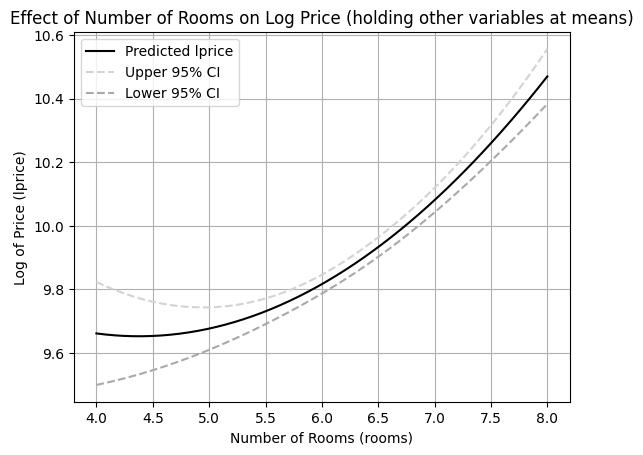

In [19]:
# plot:
plt.plot(
    X["rooms"],
    lpr_CI["mean"],
    color="black",
    linestyle="-",
    label="Predicted lprice",
)  # Plot predicted mean
plt.plot(
    X["rooms"],
    lpr_CI["mean_ci_upper"],
    color="lightgrey",
    linestyle="--",
    label="Upper 95% CI",  # Plot upper CI bound
)
plt.plot(
    X["rooms"],
    lpr_CI["mean_ci_lower"],
    color="darkgrey",
    linestyle="--",
    label="Lower 95% CI",  # Plot lower CI bound
)
plt.ylabel("Log of Price (lprice)")
plt.xlabel("Number of Rooms (rooms)")
plt.title("Effect of Number of Rooms on Log Price (holding other variables at means)")
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

**Interpretation of Effect Plot:**

The plot visually represents the inverted U-shaped relationship between the number of rooms and the log of housing price, as suggested by the regression coefficients.  The shaded area between the dashed lines represents the 95% confidence interval for the mean prediction.  This plot helps to understand the nonlinear effect of `rooms` on `lprice` and the uncertainty associated with these predictions. Effect plots are valuable tools for interpreting and presenting results from regression models with nonlinear specifications.

## 6.3 Goodness-of-Fit and Model Selection

When working with multiple regression models, we often need to compare different specifications to determine which provides the best fit or explanatory power. This section covers tools for assessing model fit and selecting among competing models.

### 6.3.1 Adjusted R-Squared

Recall that the **R-squared** measures the proportion of variation in $y$ explained by the regression:

$$R^2 = 1 - \frac{SSR}{SST} = 1 - \frac{\sum_{i=1}^n \hat{u}_i^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

**Problem with R-squared**: It **never decreases** when adding variables, even irrelevant ones! This creates a bias toward including more variables.

**Solution: Adjusted R-squared**

$$\bar{R}^2 = 1 - \frac{SSR/(n-k-1)}{SST/(n-1)} = 1 - \frac{n-1}{n-k-1}(1 - R^2)$$

where:
- $n$ = sample size
- $k$ = number of independent variables (not including intercept)
- $SSR/(n-k-1) = \hat{\sigma}^2$ = unbiased estimate of error variance

**Key Properties:**

1. **Penalizes for adding variables**: $\bar{R}^2$ can decrease when adding a variable
2. **Compares models**: Higher $\bar{R}^2$ suggests better model (among nested models)
3. **Can be negative**: Unlike $R^2$, $\bar{R}^2$ can be negative if model fits poorly
4. **Formula insight**: $\bar{R}^2 < R^2$ always, with gap increasing as more variables are added

**When to Prefer Adjusted R-squared:**

- Comparing models with **different numbers of variables**
- Assessing whether an added variable improves fit enough to justify complexity
- Avoiding overfitting in model selection

**Example: Comparing Models with Adjusted R-squared**

In [20]:
# Compare models with different numbers of variables
import wooldridge as woo

# Load data
hprice1 = woo.data('hprice1')

# Model 1: Simple model with key variables
model1 = smf.ols('np.log(price) ~ np.log(lotsize) + np.log(sqrft) + bdrms', data=hprice1).fit()

# Model 2: Add more variables
model2 = smf.ols('np.log(price) ~ np.log(lotsize) + np.log(sqrft) + bdrms + colonial + lprice', data=hprice1).fit()

# Model 3: Add even more variables
model3 = smf.ols('np.log(price) ~ np.log(lotsize) + np.log(sqrft) + bdrms + colonial + lprice + np.log(lotsize):bdrms', data=hprice1).fit()

# Compare fit statistics
comparison = pd.DataFrame({
    'Model': ['Model 1 (3 vars)', 'Model 2 (5 vars)', 'Model 3 (6 vars)'],
    'R-squared': [model1.rsquared, model2.rsquared, model3.rsquared],
    'Adj R-squared': [model1.rsquared_adj, model2.rsquared_adj, model3.rsquared_adj],
    'n': [model1.nobs, model2.nobs, model3.nobs],
    'k': [model1.df_model, model2.df_model, model3.df_model],
    'Assessment': [
        'Baseline',
        'Better' if model2.rsquared_adj > model1.rsquared_adj else 'Worse',
        'Better' if model3.rsquared_adj > model2.rsquared_adj else 'Worse'
    ]
})

display(comparison.round(4))

,Model,R-squared,Adj R-squared,n,k,Assessment
0,Model 1 (3 vars),0.643,0.6302,88.0,3.0,Baseline
1,Model 2 (5 vars),1.000,1.0000,88.0,5.0,Better
2,Model 3 (6 vars),1.000,1.0000,88.0,6.0,Better


**Interpretation**: 
- R-squared increases with every variable added (mechanical property)
- Adjusted R-squared may decrease if added variable doesn't improve fit enough
- Choose model with highest adjusted R-squared among reasonable specifications

### 6.3.2 Model Selection Criteria: AIC and BIC

While adjusted R-squared is intuitive, more sophisticated model selection criteria are often preferred in practice.

**Akaike Information Criterion (AIC)**:

$$AIC = n \ln(SSR/n) + 2(k+1)$$

**Bayesian Information Criterion (BIC)**:

$$BIC = n \ln(SSR/n) + \ln(n)(k+1)$$

**Key Differences:**

1. **Penalty strength**: BIC penalizes model complexity more heavily than AIC (when $n > 7$)
2. **Interpretation**: Lower values indicate better models (opposite of R-squared!)
3. **Consistency**: BIC is consistent (selects true model as $n \to \infty$), AIC is not
4. **Practical use**: BIC tends to select simpler models than AIC

**Example: Model Selection with AIC and BIC**

In [21]:
# Calculate AIC and BIC for models
model_selection = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'AIC': [model1.aic, model2.aic, model3.aic],
    'BIC': [model1.bic, model2.bic, model3.bic],
    'Adj R-sq': [model1.rsquared_adj, model2.rsquared_adj, model3.rsquared_adj],
    'Best by AIC': ['YES' if model1.aic == min([model1.aic, model2.aic, model3.aic]) else 'NO',
                     'YES' if model2.aic == min([model1.aic, model2.aic, model3.aic]) else 'NO',
                     'YES' if model3.aic == min([model1.aic, model2.aic, model3.aic]) else 'NO'],
    'Best by BIC': ['YES' if model1.bic == min([model1.bic, model2.bic, model3.bic]) else 'NO',
                     'YES' if model2.bic == min([model1.bic, model2.bic, model3.bic]) else 'NO',
                     'YES' if model3.bic == min([model1.bic, model2.bic, model3.bic]) else 'NO']
})

display(model_selection.round(2))

,Model,AIC,BIC,Adj R-sq,Best by AIC,Best by BIC
0,Model 1,-43.72,-33.81,0.63,NO,NO
1,Model 2,-2551.05,-2536.19,1.00,YES,YES
2,Model 3,-2550.80,-2533.46,1.00,NO,NO


**When Criteria Disagree:**

- AIC may prefer more complex model (lower penalty for parameters)
- BIC may prefer simpler model (higher penalty for parameters)
- Consider: economic theory, out-of-sample performance, interpretability

### 6.3.3 The Problem of Controlling for Too Many Variables

**More variables is not always better!** Over-controlling can cause problems:

**1. Multicollinearity**: 
- Adding many correlated variables inflates standard errors
- Reduces statistical power to detect effects
- Makes estimates unstable across samples

**2. Post-treatment bias** (from Chapter 3):
- Including variables affected by treatment blocks causal pathways
- Underestimates total effects

**3. Overfitting**:
- Model fits sample noise instead of population relationship
- Poor out-of-sample prediction
- False sense of precision

**4. Degrees of freedom loss**:
- With $k$ close to $n$, little information for estimation
- Standard errors become unreliable
- R-squared artificially high

**Example: Overfitting Demonstration**

In [22]:
# Demonstrate overfitting with too many variables
np.random.seed(42)
n = 50  # Small sample

# True DGP: y depends only on x1
x1 = stats.norm.rvs(0, 1, size=n)
x_noise = stats.norm.rvs(0, 1, size=(n, 10))  # 10 irrelevant variables
y_true = 2 + 3 * x1
y = y_true + stats.norm.rvs(0, 2, size=n)

# Create dataframe
data_overfit = pd.DataFrame({'y': y, 'x1': x1})
for i in range(10):
    data_overfit[f'noise{i+1}'] = x_noise[:, i]

# Simple model (correct specification)
simple_model = smf.ols('y ~ x1', data=data_overfit).fit()

# Overfit model (includes irrelevant variables)
overfit_formula = 'y ~ x1 + ' + ' + '.join([f'noise{i+1}' for i in range(10)])
overfit_model = smf.ols(overfit_formula, data=data_overfit).fit()

# Compare
overfit_comparison = pd.DataFrame({
    'Model': ['Simple (True)', 'Overfit (11 vars)'],
    'R-squared': [simple_model.rsquared, overfit_model.rsquared],
    'Adj R-squared': [simple_model.rsquared_adj, overfit_model.rsquared_adj],
    'AIC': [simple_model.aic, overfit_model.aic],
    'BIC': [simple_model.bic, overfit_model.bic],
    'SE(x1)': [simple_model.bse['x1'], overfit_model.bse['x1']],
    'Assessment': ['Better (simpler, more precise)', 'Worse (overfit, imprecise)']
})

display(overfit_comparison.round(4))

,Model,R-squared,Adj R-squared,AIC,BIC,SE(x1),Assessment
0,Simple (True),0.6641,0.6571,206.3576,210.1817,0.2859,"Better (simpler, more precise)"
1,Overfit (11 vars),0.7479,0.6749,212.0012,234.9455,0.2942,"Worse (overfit, imprecise)"


**Lessons:**
- R-squared higher in overfit model (misleading!)
- Adjusted R-squared, AIC, BIC all prefer simple model
- Standard error on x1 inflated in overfit model (less precision)
- **Occam's Razor**: Prefer simpler models when in doubt

:::{warning} Guidelines for Variable Inclusion
:class: dropdown

**DO include variables if:**
- Economic theory suggests they're important confounders
- Omitting them would cause bias in key coefficient
- They significantly improve fit (F-test, adjusted R-squared)
- They're needed for policy evaluation

**DON'T include variables if:**
- They're post-treatment outcomes
- They're perfectly correlated with other variables
- They're only included to maximize R-squared
- You're on a "fishing expedition" for significance

**Rule of Thumb**: Aim for roughly $n/10$ to $n/20$ variables maximum. With $n=100$, keep $k \leq 5-10$.
:::

### 6.3.4 Log Transformation Special Cases

**Problem with log(0):**

Variables like income, sales, or participation rates can be zero. Taking $\log(0)$ is undefined!

**Common "Solution": log(1 + y)**

Some researchers use $\log(1 + y)$ to handle zeros:

In [23]:
# Example with zeros
income = np.array([0, 1000, 5000, 10000, 50000])
log_income_plus1 = np.log(1 + income)

**Problems with log(1 + y):**

1. **Interpretation changes**: Coefficient no longer represents percentage change
   - With $\log(y)$: 1-unit change in $x$ → $100\beta$ percent change in $y$
   - With $\log(1+y)$: Interpretation unclear, especially when $y$ is large

2. **Asymmetry**: Works differently for small vs large values
   - $\log(1 + 1) = 0.693$
   - $\log(1 + 1000) = 6.908$
   - Transformation more dramatic for small values

3. **Economic implausibility**: Adding 1 to income or sales lacks economic meaning

**Better Alternatives:**

1. **Inverse hyperbolic sine (IHS)**: $\text{asinh}(y) = \log(y + \sqrt{y^2 + 1})$
   - Handles zeros and negatives
   - Approximately $\log(y)$ for large $y$
   - More interpretable than $\log(1+y)$

2. **Tobit model** (Chapter 17): Explicitly model zeros as censoring

3. **Two-part model**: Model (1) whether $y > 0$ and (2) level of $y$ given $y > 0$

**Predicting Levels from Log Models:**

When dependent variable is $\log(y)$, predicting the **level** of $y$ requires care:

**Naive (WRONG)**:
$$\hat{y} = \exp(\hat{\beta}_0 + \hat{\beta}_1 x_1 + \cdots + \hat{\beta}_k x_k)$$

**Corrected (semi-log retransformation)**:
$$\hat{y} = \exp(\hat{\beta}_0 + \hat{\beta}_1 x_1 + \cdots + \hat{\beta}_k x_k) \times \exp(\hat{\sigma}^2/2)$$

where $\hat{\sigma}^2 = SSR/(n-k-1)$.

**Reason**: Jensen's inequality - $E[\exp(u)] \neq \exp(E[u])$ when $u$ is random.

**Example: Correct Prediction from Log Model**

In [24]:
# Estimate wage equation
wage1 = woo.data('wage1')
log_wage_model = smf.ols('np.log(wage) ~ educ + exper + tenure', data=wage1).fit()

# Predict for specific person
new_person = pd.DataFrame({'educ': [16], 'exper': [10], 'tenure': [5]})

# Naive prediction (WRONG)
log_wage_pred = log_wage_model.predict(new_person)
wage_naive = np.exp(log_wage_pred.values[0])

# Corrected prediction (RIGHT)
sigma_sq = log_wage_model.mse_resid  # = SSR / (n-k-1)
smearing_factor = np.exp(sigma_sq / 2)
wage_corrected = np.exp(log_wage_pred.values[0]) * smearing_factor

retransform_comparison = pd.DataFrame({
    'Method': ['Predicted log(wage)', 'Naive: exp(predicted)', 'Corrected: exp(pred) * correction'],
    'Value': [log_wage_pred.values[0], wage_naive, wage_corrected],
    'Interpretation': [
        'Log scale',
        'Underestimates true expected wage',
        'Proper prediction of expected wage level'
    ]
})

display(retransform_comparison.round(4))

,Method,Value,Interpretation
0,Predicted log(wage),1.9084,Log scale
1,Naive: exp(predicted),6.7421,Underestimates true expected wage
2,Corrected: exp(pred) * correction,7.4302,Proper prediction of expected wage level


## 6.4 Residual Analysis

**Residuals** ($\hat{u}_i = y_i - \hat{y}_i$) provide crucial diagnostic information about model adequacy. Systematic patterns in residuals signal violations of Gauss-Markov assumptions.

### 6.4.1 What Residuals Should Look Like

Under the classical assumptions (MLR.1-MLR.6), residuals should:

1. **Have mean zero** (guaranteed by OLS)
2. **Be uncorrelated with predictors** (guaranteed by OLS)
3. **Have constant variance** (homoskedasticity, MLR.5)
4. **Show no patterns** when plotted against fitted values or predictors
5. **Be approximately normal** (MLR.6, less critical for large samples)

### 6.4.2 Residual Plots for Diagnostics

**Plot 1: Residuals vs Fitted Values**

Most important diagnostic plot! Look for:
- **Horizontal band**: Good (homoskedasticity)
- **Funnel shape**: Heteroskedasticity (Chapter 8)
- **Curved pattern**: Functional form misspecification
- **Outliers**: Influential observations

**Plot 2: Residuals vs Each Predictor**

Checks for:
- Nonlinear relationships missed by model
- Need for quadratic or interaction terms

**Plot 3: Q-Q Plot (Quantile-Quantile)**

Checks normality assumption:
- Points on diagonal: Normal
- Deviations at tails: Heavy or light tails
- S-shape: Skewed distribution

**Plot 4: Scale-Location Plot**

Alternative check for homoskedasticity:
- Plots $\sqrt{|\text{residuals}|}$ vs fitted values
- Horizontal line suggests constant variance

**Example: Comprehensive Residual Analysis**

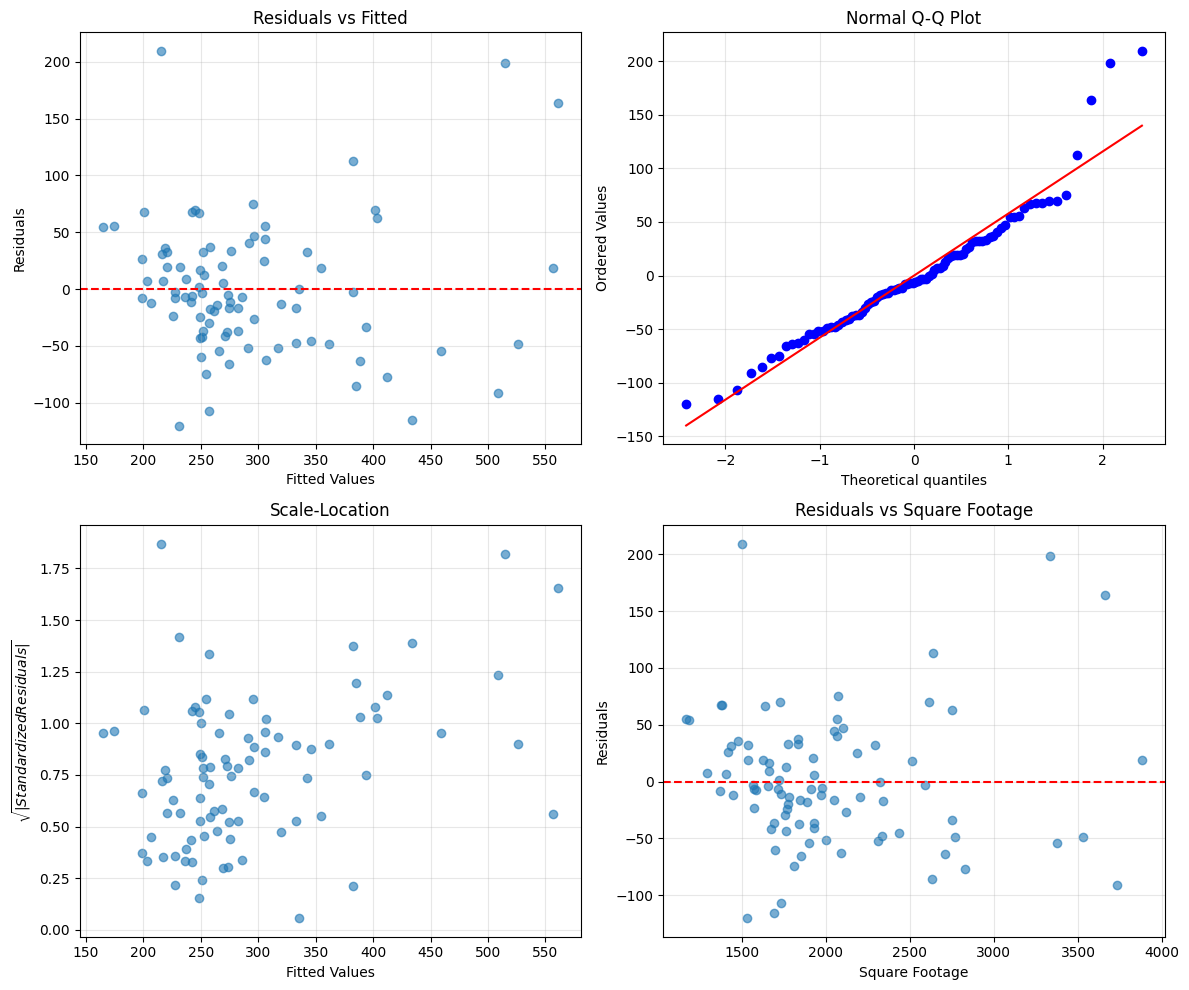

In [25]:
# Estimate model
hprice1 = woo.data('hprice1')
house_model = smf.ols('price ~ lotsize + sqrft + bdrms', data=hprice1).fit()

# Get residuals and fitted values
residuals = house_model.resid
fitted = house_model.fittedvalues
standardized_resid = house_model.resid_pearson

# Create 2x2 subplot for diagnostics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Residuals vs Fitted
axes[0, 0].scatter(fitted, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Q-Q Plot for normality
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scale-Location (sqrt of standardized residuals)
axes[1, 0].scatter(fitted, np.sqrt(np.abs(standardized_resid)), alpha=0.6)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
axes[1, 0].set_title('Scale-Location')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals vs sqrft (key predictor)
axes[1, 1].scatter(hprice1['sqrft'], residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Square Footage')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Square Footage')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**How to Interpret:**

1. **Funnel in residuals vs fitted** → Heteroskedasticity (use robust SEs, Chapter 8)
2. **Curved pattern** → Add quadratic/interaction terms
3. **Deviations from Q-Q diagonal** → Non-normal errors (okay if $n$ is large)
4. **Few extreme outliers** → Check for data errors or influential observations

### 6.4.3 Identifying Influential Observations

Some observations have disproportionate influence on regression results. Key diagnostics:

**1. Leverage**: How far $x_i$ is from $\bar{x}$
- High leverage $\to$ observation can pull regression line

**2. Studentized Residuals**: Residuals standardized by their standard error
- $|r_i| > 3$ suggests outlier

**3. Cook's Distance**: Combined measure of leverage and residual size
- $D_i > 4/n$ suggests influential observation
- $D_i > 1$ is very influential

**Example: Influence Diagnostics**

,Observation,Leverage,Cooks D,Stud. Resid,Influential
76,76,0.8427,31.7505,-4.8682,True
72,72,0.1371,0.3451,2.9471,True
41,41,0.0999,0.3397,3.4995,True
62,62,0.2191,0.1141,1.2752,True
47,47,0.1357,0.1056,-1.6403,True


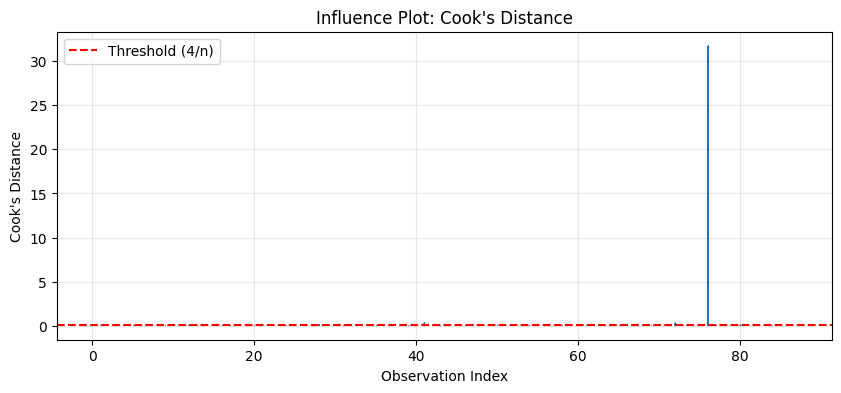

In [26]:
# Calculate influence measures
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(house_model)
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]
studentized_resid = influence.resid_studentized_internal

# Identify influential observations
influential = pd.DataFrame({
    'Observation': range(len(leverage)),
    'Leverage': leverage,
    'Cooks D': cooks_d,
    'Stud. Resid': studentized_resid,
    'Influential': (cooks_d > 4/len(leverage)) | (np.abs(studentized_resid) > 3)
})

# Show top 5 most influential
top_influential = influential.nlargest(5, 'Cooks D')
display(top_influential.round(4))

# Plot Cook's Distance
plt.figure(figsize=(10, 4))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=' ')
plt.axhline(y=4/len(leverage), color='r', linestyle='--', label='Threshold (4/n)')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Influence Plot: Cook's Distance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**What to Do with Influential Observations:**

1. **Check for data errors**: Typos, incorrect units, etc.
2. **Investigate substantively**: Are they legitimate unusual cases?
3. **Report sensitivity**: Show results with and without influential observations
4. **Use robust methods**: Robust regression (less sensitive to outliers)
5. **DON'T automatically delete**: May represent important heterogeneity

:::{important} Residual Analysis Best Practices
:class: dropdown

**Always**:
- Plot residuals vs fitted values (most important!)
- Check for a few influential observations
- Investigate any clear patterns

**Often**:
- Plot residuals vs key predictors
- Check Q-Q plot if assuming normality
- Calculate Cook's distance for leverage

**Sometimes**:
- Use formal tests (Breusch-Pagan, White for heteroskedasticity)
- Apply transformations based on residual patterns
- Refit model excluding highly influential observations

**Never**:
- Delete observations just to improve R-squared
- Ignore systematic patterns in residuals
- Assume residuals are fine without checking
:::

## Chapter Summary

This chapter covered essential practical issues in multiple regression analysis, focusing on model specification, functional form, and diagnostic checking. These tools help you build better models and avoid common pitfalls.

**Key Concepts:**

**1. Effects of Data Scaling (Section 6.1.1-6.1.2)**:
- Multiplying $y$ by constant scales $\hat{\beta}$, $\text{se}(\hat{\beta})$, and $SSR$ by same constant
- Multiplying $x_j$ by constant scales $\hat{\beta}_j$ and $\text{se}(\hat{\beta}_j)$ by reciprocal
- **t-statistics and R-squared are invariant** to scaling
- **Standardized coefficients** (beta coefficients) allow comparing importance across variables

**2. Functional Form (Section 6.1.3-6.1.6)**:
- **Log transformations**: Interpret coefficients as percentage effects, invariant to scaling
- **Log-linear**: $\beta$ = percentage change in $y$ per unit change in $x$
- **Log-log**: $\beta$ = elasticity (percentage change in $y$ per 1% change in $x$)
- **Quadratic terms**: Allow nonlinear (U-shaped or inverted-U) relationships
- **Interaction terms**: Allow effect of $x_1$ to depend on level of $x_2$

**3. Goodness-of-Fit and Model Selection (Section 6.3)**:
- **Adjusted R-squared** penalizes adding variables, prefer for model comparison
- **AIC and BIC**: Lower is better, BIC penalizes complexity more heavily
- **Too many variables**: Causes multicollinearity, overfitting, imprecise estimates
- **Occam's Razor**: Prefer simpler models when fit is similar

**4. Special Issues with Logs (Section 6.3.4)**:
- **log(1 + y)** has interpretation problems - avoid when possible
- **Inverse hyperbolic sine** better for handling zeros
- **Predicting levels from log(y)**: Need retransformation correction $\exp(\hat{\sigma}^2/2)$

**5. Prediction (Section 6.2)**:
- **Confidence interval** for $E(y|x)$: Narrower, estimates mean
- **Prediction interval** for new $y$: Wider, accounts for individual variation
- Prediction intervals always wider than confidence intervals by factor of $\sqrt{1 + \text{leverage}}$

**6. Residual Analysis (Section 6.4)**:
- **Residual plots** reveal violations of assumptions
- **Patterns** suggest heteroskedasticity or functional form problems
- **Cook's distance** identifies influential observations
- Always check residuals before trusting results!

**Practical Workflow for Model Building:**

1. **Start simple**: Begin with linear specification, key variables
2. **Check residuals**: Look for patterns suggesting needed transformations
3. **Add complexity thoughtfully**: Quadratics, interactions, logs as theory/diagnostics suggest
4. **Compare models**: Use adjusted R-squared, AIC, BIC
5. **Test restrictions**: F-tests for joint significance of added terms
6. **Validate**: Check out-of-sample performance, sensitivity to outliers
7. **Interpret carefully**: Remember scaling, functional form implications

**Common Mistakes to Avoid:**

- ✗ Including too many variables (overfitting)
- ✗ Chasing high R-squared without theory
- ✗ Ignoring residual patterns
- ✗ Misinterpreting log coefficients
- ✗ Using prediction intervals when you need confidence intervals (or vice versa)
- ✗ Deleting influential observations without investigation

**Connections to Other Chapters:**

- **Chapter 3**: Bad controls, multicollinearity, functional form as specification issues
- **Chapter 5**: Model selection relates to consistency (correct specification)
- **Chapter 8**: Heteroskedasticity revealed by residual analysis, affects prediction intervals
- **Chapter 9**: RESET test for functional form, proxy variables

**Looking Forward:**

- **Chapter 7**: Dummy variables (discrete functional form)
- **Chapter 8**: Heteroskedasticity (variance patterns in residuals)  
- **Chapter 9**: Specification tests (formal checks of functional form)

**The Bottom Line:**

Regression is an art as much as a science. Good practice combines:
- **Economic theory**: What variables and functional forms make sense?
- **Diagnostic checking**: Do residuals reveal problems?
- **Model comparison**: Which specification fits best without overfitting?
- **Robust inference**: Use methods that work even when assumptions fail

Master these tools and you'll build better, more reliable regression models!